# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

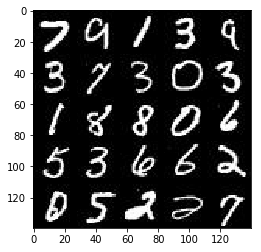

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

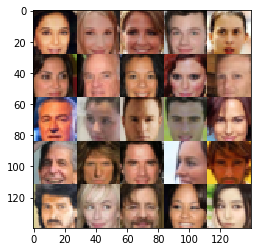

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # input is 28x28
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape())
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape())
        
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape())
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*1024))
        #print(flat.get_shape())
        
        # Fully connected layer
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out.get_shape())
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = (not is_train)):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        #print(x1.get_shape())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        # exludes BN on layer 1
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape())
        
        # Hidden layer 2
        x2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape())
        
        # Hidden layer 3
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu2.get_shape())
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # needs to return 28x28        
        
        out = tf.tanh(logits)
        #print(out.get_shape())
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses=[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
                
                # Step Counter
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})

                # Print loss
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                
                # Show every 100 steps
                if steps % 100 == 0:
                    #show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 22.6276
Epoch 1/2... Discriminator Loss: 2.0785... Generator Loss: 0.3817
Epoch 1/2... Discriminator Loss: 0.1675... Generator Loss: 7.7021
Epoch 1/2... Discriminator Loss: 6.7505... Generator Loss: 0.0054
Epoch 1/2... Discriminator Loss: 4.3071... Generator Loss: 0.0295
Epoch 1/2... Discriminator Loss: 0.4839... Generator Loss: 2.2489
Epoch 1/2... Discriminator Loss: 0.2068... Generator Loss: 4.6923
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.2504
Epoch 1/2... Discriminator Loss: 1.8376... Generator Loss: 10.5083
Epoch 1/2... Discriminator Loss: 0.1199... Generator Loss: 3.2673


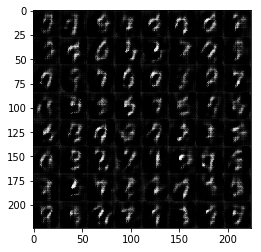

Epoch 1/2... Discriminator Loss: 1.5674... Generator Loss: 0.2907
Epoch 1/2... Discriminator Loss: 0.0694... Generator Loss: 4.6330
Epoch 1/2... Discriminator Loss: 0.1999... Generator Loss: 2.0641
Epoch 1/2... Discriminator Loss: 0.0348... Generator Loss: 3.9678
Epoch 1/2... Discriminator Loss: 0.3130... Generator Loss: 2.9901
Epoch 1/2... Discriminator Loss: 0.5281... Generator Loss: 2.1149
Epoch 1/2... Discriminator Loss: 0.0227... Generator Loss: 6.7255
Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 7.8918
Epoch 1/2... Discriminator Loss: 0.3297... Generator Loss: 3.7987
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 2.6949


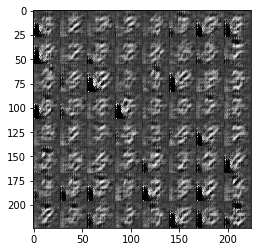

Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 2.0102
Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 3.2785
Epoch 1/2... Discriminator Loss: 0.3116... Generator Loss: 2.5215
Epoch 1/2... Discriminator Loss: 0.3110... Generator Loss: 8.9652
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 5.7350
Epoch 1/2... Discriminator Loss: 0.1130... Generator Loss: 7.3983
Epoch 1/2... Discriminator Loss: 0.1839... Generator Loss: 6.0700
Epoch 1/2... Discriminator Loss: 0.2690... Generator Loss: 3.6663
Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 2.1019
Epoch 1/2... Discriminator Loss: 0.1681... Generator Loss: 5.7034


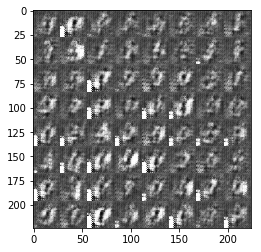

Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.9144
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 0.2581... Generator Loss: 3.7739
Epoch 1/2... Discriminator Loss: 2.9775... Generator Loss: 0.3115
Epoch 1/2... Discriminator Loss: 6.3673... Generator Loss: 14.5910
Epoch 1/2... Discriminator Loss: 8.3737... Generator Loss: 0.0071
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 5.6661
Epoch 1/2... Discriminator Loss: 0.6922... Generator Loss: 2.1600
Epoch 1/2... Discriminator Loss: 0.0136... Generator Loss: 15.8453
Epoch 1/2... Discriminator Loss: 0.2043... Generator Loss: 3.4853


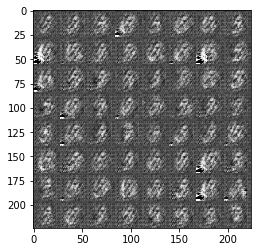

Epoch 1/2... Discriminator Loss: 0.2247... Generator Loss: 4.4972
Epoch 1/2... Discriminator Loss: 0.0261... Generator Loss: 10.9118
Epoch 1/2... Discriminator Loss: 3.9495... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 3.8803... Generator Loss: 0.0522
Epoch 1/2... Discriminator Loss: 5.8385... Generator Loss: 0.0084
Epoch 1/2... Discriminator Loss: 3.6627... Generator Loss: 0.2621
Epoch 1/2... Discriminator Loss: 5.7498... Generator Loss: 0.0260
Epoch 1/2... Discriminator Loss: 6.4527... Generator Loss: 0.0044
Epoch 1/2... Discriminator Loss: 0.0279... Generator Loss: 8.6840
Epoch 1/2... Discriminator Loss: 0.3585... Generator Loss: 3.6526


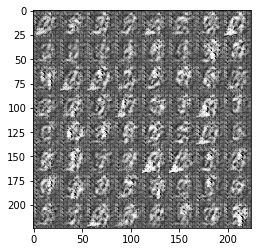

Epoch 1/2... Discriminator Loss: 0.2282... Generator Loss: 3.3776
Epoch 1/2... Discriminator Loss: 0.1031... Generator Loss: 3.5146
Epoch 1/2... Discriminator Loss: 2.9671... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 1.9375
Epoch 1/2... Discriminator Loss: 3.9974... Generator Loss: 0.0582
Epoch 1/2... Discriminator Loss: 0.3203... Generator Loss: 6.9801
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 3.0665
Epoch 1/2... Discriminator Loss: 4.5732... Generator Loss: 0.0219
Epoch 1/2... Discriminator Loss: 3.1645... Generator Loss: 5.8430
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 0.8248


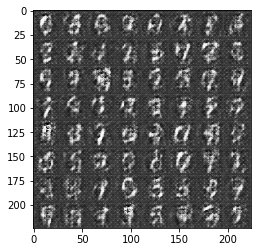

Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 6.0922
Epoch 1/2... Discriminator Loss: 0.1822... Generator Loss: 5.0423
Epoch 1/2... Discriminator Loss: 2.3991... Generator Loss: 3.8422
Epoch 1/2... Discriminator Loss: 4.7698... Generator Loss: 0.0126
Epoch 1/2... Discriminator Loss: 5.5326... Generator Loss: 0.0048
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 0.1767... Generator Loss: 3.0627
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 3.0949... Generator Loss: 0.0487
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.5677


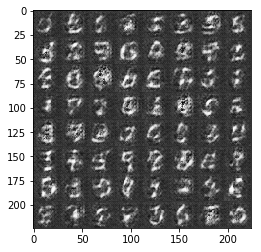

Epoch 1/2... Discriminator Loss: 4.6805... Generator Loss: 0.0136
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 2.0280... Generator Loss: 3.1090
Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 1.9176
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.3701
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.8918
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.2515
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 4.3471
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 5.4961
Epoch 1/2... Discriminator Loss: 7.3140... Generator Loss: 6.7846


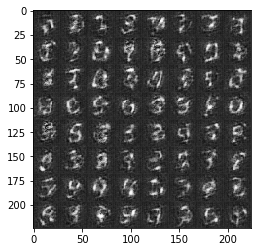

Epoch 1/2... Discriminator Loss: 4.2770... Generator Loss: 0.0220
Epoch 1/2... Discriminator Loss: 2.1808... Generator Loss: 0.1892
Epoch 1/2... Discriminator Loss: 3.1101... Generator Loss: 0.0683
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 2.7751... Generator Loss: 0.1470
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 1.7756
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.2633
Epoch 1/2... Discriminator Loss: 0.1903... Generator Loss: 2.5651


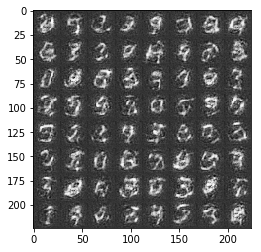

Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 2.4298
Epoch 1/2... Discriminator Loss: 0.0337... Generator Loss: 4.9946
Epoch 2/2... Discriminator Loss: 0.0711... Generator Loss: 4.2061
Epoch 2/2... Discriminator Loss: 0.2581... Generator Loss: 2.0450
Epoch 2/2... Discriminator Loss: 0.5222... Generator Loss: 1.5249
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.3110... Generator Loss: 1.6046
Epoch 2/2... Discriminator Loss: 0.2764... Generator Loss: 1.9297
Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 0.5470
Epoch 2/2... Discriminator Loss: 6.6228... Generator Loss: 0.0051
Epoch 2/2... Discriminator Loss: 6.1182... Generator Loss: 0.0029


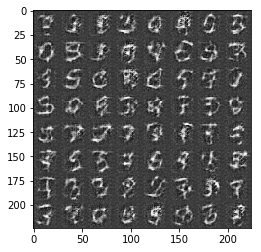

Epoch 2/2... Discriminator Loss: 4.9046... Generator Loss: 0.0111
Epoch 2/2... Discriminator Loss: 4.9923... Generator Loss: 0.0087
Epoch 2/2... Discriminator Loss: 4.5614... Generator Loss: 0.0229
Epoch 2/2... Discriminator Loss: 4.7521... Generator Loss: 0.0178
Epoch 2/2... Discriminator Loss: 3.8928... Generator Loss: 0.0523
Epoch 2/2... Discriminator Loss: 4.8829... Generator Loss: 0.0104
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 4.2404... Generator Loss: 0.0186
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 2.7836... Generator Loss: 0.4994


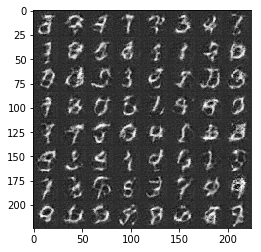

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.7100... Generator Loss: 4.3233
Epoch 2/2... Discriminator Loss: 4.3158... Generator Loss: 0.0197
Epoch 2/2... Discriminator Loss: 4.2541... Generator Loss: 0.0309
Epoch 2/2... Discriminator Loss: 5.3215... Generator Loss: 0.0146
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 0.1088... Generator Loss: 2.6977
Epoch 2/2... Discriminator Loss: 2.9620... Generator Loss: 0.0929
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.3266


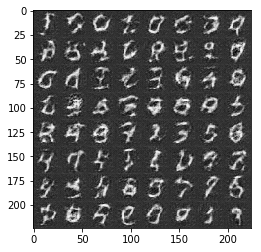

Epoch 2/2... Discriminator Loss: 0.1735... Generator Loss: 2.4941
Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 0.2767
Epoch 2/2... Discriminator Loss: 0.4309... Generator Loss: 1.9456
Epoch 2/2... Discriminator Loss: 0.3689... Generator Loss: 2.5757
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 0.1352... Generator Loss: 3.2035
Epoch 2/2... Discriminator Loss: 3.9597... Generator Loss: 0.0292
Epoch 2/2... Discriminator Loss: 6.9727... Generator Loss: 8.3160
Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 1.0927
Epoch 2/2... Discriminator Loss: 4.9084... Generator Loss: 0.0122


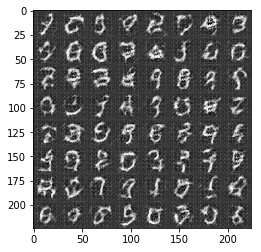

Epoch 2/2... Discriminator Loss: 7.8641... Generator Loss: 9.2833
Epoch 2/2... Discriminator Loss: 3.7756... Generator Loss: 0.2593
Epoch 2/2... Discriminator Loss: 3.3487... Generator Loss: 0.0566
Epoch 2/2... Discriminator Loss: 3.8364... Generator Loss: 0.0573
Epoch 2/2... Discriminator Loss: 1.9847... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 2.6589... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.6101
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 1.5641


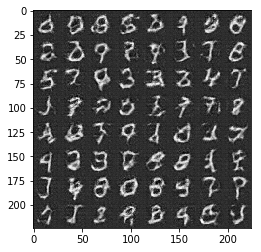

Epoch 2/2... Discriminator Loss: 0.2971... Generator Loss: 1.9771
Epoch 2/2... Discriminator Loss: 0.1204... Generator Loss: 2.9778
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 1.6649
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 1.7488
Epoch 2/2... Discriminator Loss: 1.5435... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.7881
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.1041
Epoch 2/2... Discriminator Loss: 0.3035... Generator Loss: 2.5072
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.2355... Generator Loss: 1.7937


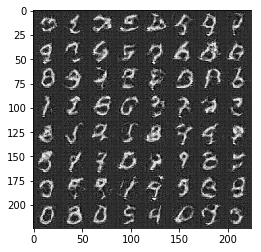

Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 2.5749
Epoch 2/2... Discriminator Loss: 0.1416... Generator Loss: 2.3686
Epoch 2/2... Discriminator Loss: 26.2773... Generator Loss: 29.0950
Epoch 2/2... Discriminator Loss: 2.3375... Generator Loss: 7.0862
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 3.8930... Generator Loss: 0.0730
Epoch 2/2... Discriminator Loss: 2.2367... Generator Loss: 0.1758
Epoch 2/2... Discriminator Loss: 5.0556... Generator Loss: 0.0093
Epoch 2/2... Discriminator Loss: 4.6630... Generator Loss: 0.0124
Epoch 2/2... Discriminator Loss: 2.3286... Generator Loss: 2.2472


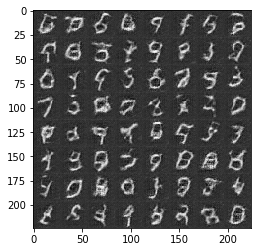

Epoch 2/2... Discriminator Loss: 3.9993... Generator Loss: 0.1130
Epoch 2/2... Discriminator Loss: 4.5971... Generator Loss: 0.0304
Epoch 2/2... Discriminator Loss: 1.8069... Generator Loss: 0.4352
Epoch 2/2... Discriminator Loss: 3.0662... Generator Loss: 0.2566
Epoch 2/2... Discriminator Loss: 2.7457... Generator Loss: 0.2135
Epoch 2/2... Discriminator Loss: 1.5128... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 1.9790... Generator Loss: 0.2038
Epoch 2/2... Discriminator Loss: 1.5720... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.8278... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.3549


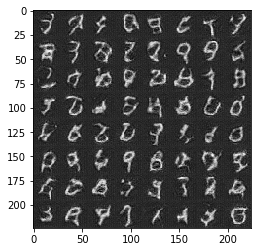

Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 0.2001... Generator Loss: 2.6265
Epoch 2/2... Discriminator Loss: 0.4461... Generator Loss: 1.3570
Epoch 2/2... Discriminator Loss: 1.9047... Generator Loss: 0.1799
Epoch 2/2... Discriminator Loss: 2.0062... Generator Loss: 0.3552
Epoch 2/2... Discriminator Loss: 7.7449... Generator Loss: 10.4164
Epoch 2/2... Discriminator Loss: 3.1001... Generator Loss: 5.8284
Epoch 2/2... Discriminator Loss: 5.1786... Generator Loss: 0.0093
Epoch 2/2... Discriminator Loss: 3.3344... Generator Loss: 0.0791
Epoch 2/2... Discriminator Loss: 2.9865... Generator Loss: 0.1058


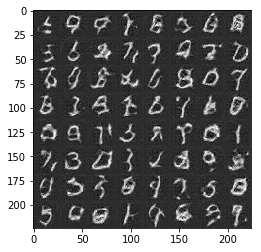

Epoch 2/2... Discriminator Loss: 4.6458... Generator Loss: 0.0145
Epoch 2/2... Discriminator Loss: 5.3696... Generator Loss: 0.0062
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.7586


In [21]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.6734
Epoch 1/1... Discriminator Loss: 13.6583... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 11.7759... Generator Loss: 11.2580
Epoch 1/1... Discriminator Loss: 5.3112... Generator Loss: 22.6075
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 9.3267
Epoch 1/1... Discriminator Loss: 0.2414... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 0.0303... Generator Loss: 4.1877
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 18.0765
Epoch 1/1... Discriminator Loss: 7.6164... Generator Loss: 0.0007
Epoch 1/1... Discriminator Loss: 3.6597... Generator Loss: 0.2479


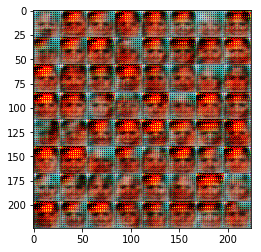

Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 7.5358
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 4.6054
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 3.0167
Epoch 1/1... Discriminator Loss: 6.4942... Generator Loss: 0.0070
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 3.0233
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.7796
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 4.6939


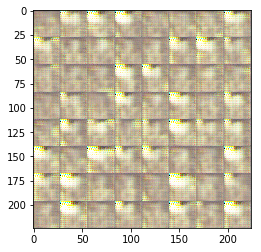

Epoch 1/1... Discriminator Loss: 0.2653... Generator Loss: 6.4068
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 4.5455
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 3.9047
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 7.2101
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 2.5484
Epoch 1/1... Discriminator Loss: 7.6447... Generator Loss: 13.9625
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 2.8973... Generator Loss: 0.4766


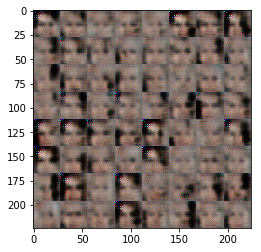

Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.5058
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 3.4768
Epoch 1/1... Discriminator Loss: 2.2430... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 3.8064
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.2037... Generator Loss: 3.9641
Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 4.1804
Epoch 1/1... Discriminator Loss: 3.1234... Generator Loss: 0.0539
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 3.4892
Epoch 1/1... Discriminator Loss: 4.1386... Generator Loss: 0.0206


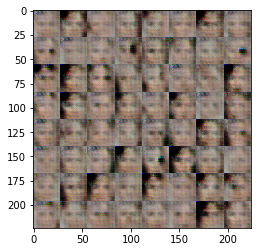

Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 3.1603
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 1.9324... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 2.3980
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 2.3428
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.4562
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 4.3501
Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 0.9626


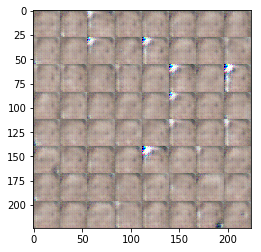

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 6.1732
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 14.1732
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 4.2066
Epoch 1/1... Discriminator Loss: 4.0153... Generator Loss: 0.0411
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 3.3406
Epoch 1/1... Discriminator Loss: 2.1870... Generator Loss: 0.2911
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 4.1007
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 4.5037


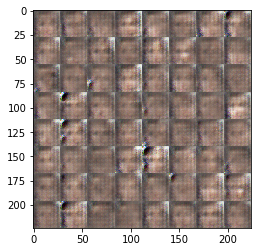

Epoch 1/1... Discriminator Loss: 6.6580... Generator Loss: 14.6555
Epoch 1/1... Discriminator Loss: 3.5479... Generator Loss: 4.7895
Epoch 1/1... Discriminator Loss: 4.6043... Generator Loss: 5.9244
Epoch 1/1... Discriminator Loss: 1.9665... Generator Loss: 4.4404
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 2.5742
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 7.0256
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 3.8980... Generator Loss: 0.1740
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 4.4869


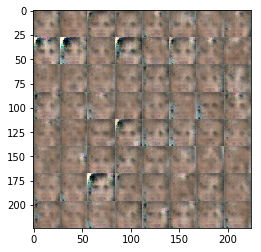

Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 3.9541
Epoch 1/1... Discriminator Loss: 2.3115... Generator Loss: 4.3622
Epoch 1/1... Discriminator Loss: 4.0943... Generator Loss: 0.0630
Epoch 1/1... Discriminator Loss: 2.2834... Generator Loss: 4.2063
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 3.6017... Generator Loss: 0.0604
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 7.6517
Epoch 1/1... Discriminator Loss: 7.1069... Generator Loss: 9.5261
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.5666


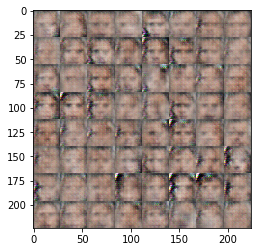

Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.5987
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 6.1085
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 6.9678
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 2.2710
Epoch 1/1... Discriminator Loss: 1.7936... Generator Loss: 0.2556
Epoch 1/1... Discriminator Loss: 2.4229... Generator Loss: 1.8486
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 4.5380


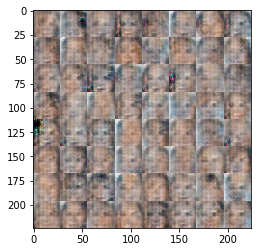

Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 10.3168
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 3.7246
Epoch 1/1... Discriminator Loss: 4.8088... Generator Loss: 7.7957
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 3.2634
Epoch 1/1... Discriminator Loss: 3.1047... Generator Loss: 0.0799
Epoch 1/1... Discriminator Loss: 2.9496... Generator Loss: 0.1299
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 7.9244
Epoch 1/1... Discriminator Loss: 5.1621... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 2.1345... Generator Loss: 0.1685


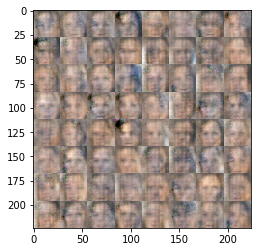

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 2.0988... Generator Loss: 0.1603
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.8326
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 2.0046... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 11.1832
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.7500


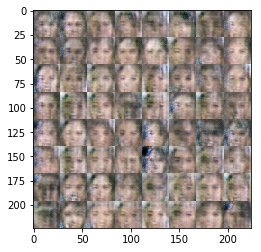

Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 0.2314... Generator Loss: 2.3897
Epoch 1/1... Discriminator Loss: 3.5030... Generator Loss: 0.0654
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 3.4910... Generator Loss: 0.0468
Epoch 1/1... Discriminator Loss: 5.3229... Generator Loss: 0.0159
Epoch 1/1... Discriminator Loss: 4.2779... Generator Loss: 0.0183
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.8796... Generator Loss: 0.1951
Epoch 1/1... Discriminator Loss: 3.7483... Generator Loss: 0.0309


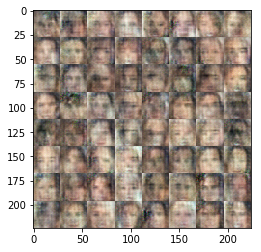

Epoch 1/1... Discriminator Loss: 2.1710... Generator Loss: 3.9296
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.8969
Epoch 1/1... Discriminator Loss: 5.5884... Generator Loss: 0.0093
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 2.1739... Generator Loss: 0.1447
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 3.9113
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 1.8916


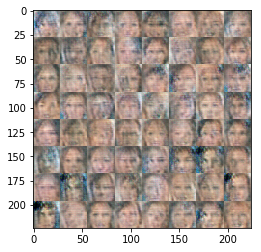

Epoch 1/1... Discriminator Loss: 4.1331... Generator Loss: 0.0371
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 5.4106
Epoch 1/1... Discriminator Loss: 4.3127... Generator Loss: 0.0141
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 2.8745... Generator Loss: 0.1413
Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 2.0397
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 2.5407... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 3.2622... Generator Loss: 0.0433
Epoch 1/1... Discriminator Loss: 1.9052... Generator Loss: 2.5361


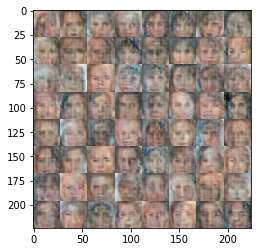

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.7512
Epoch 1/1... Discriminator Loss: 2.2330... Generator Loss: 0.1396
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 2.4043... Generator Loss: 0.2164
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 5.4002... Generator Loss: 0.0068
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 3.2870... Generator Loss: 0.1013


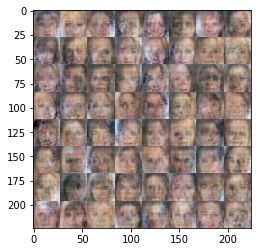

Epoch 1/1... Discriminator Loss: 1.8157... Generator Loss: 3.4440
Epoch 1/1... Discriminator Loss: 3.7381... Generator Loss: 2.6568
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 2.0634... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 3.8262... Generator Loss: 0.0255
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.8799


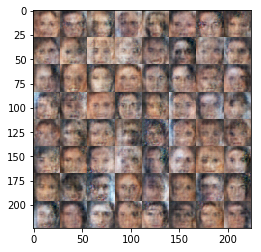

Epoch 1/1... Discriminator Loss: 3.3427... Generator Loss: 0.0399
Epoch 1/1... Discriminator Loss: 1.8748... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 1.9416... Generator Loss: 2.5215
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 3.1391... Generator Loss: 0.0513
Epoch 1/1... Discriminator Loss: 2.8424... Generator Loss: 0.0751
Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.3075
Epoch 1/1... Discriminator Loss: 3.9489... Generator Loss: 0.0251
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.7980... Generator Loss: 0.2741


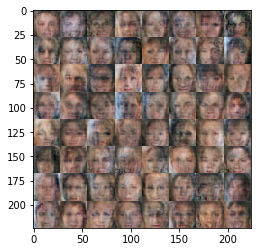

Epoch 1/1... Discriminator Loss: 2.1529... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 0.2505
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 2.3115... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 3.9112... Generator Loss: 0.0245
Epoch 1/1... Discriminator Loss: 2.7269... Generator Loss: 0.0810
Epoch 1/1... Discriminator Loss: 3.0916... Generator Loss: 0.0564
Epoch 1/1... Discriminator Loss: 2.5651... Generator Loss: 0.1089
Epoch 1/1... Discriminator Loss: 4.3620... Generator Loss: 0.0173
Epoch 1/1... Discriminator Loss: 2.1280... Generator Loss: 0.1678


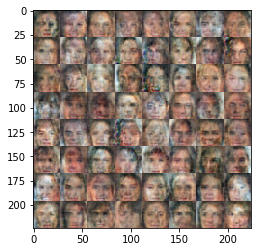

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.3244
Epoch 1/1... Discriminator Loss: 3.4842... Generator Loss: 0.0331
Epoch 1/1... Discriminator Loss: 3.9900... Generator Loss: 0.0280
Epoch 1/1... Discriminator Loss: 2.9326... Generator Loss: 0.0798
Epoch 1/1... Discriminator Loss: 1.9242... Generator Loss: 0.1744
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 2.1439... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 2.7739... Generator Loss: 0.0759


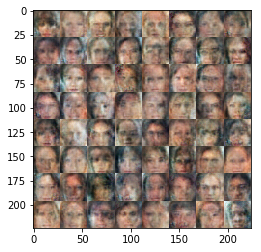

Epoch 1/1... Discriminator Loss: 4.8933... Generator Loss: 0.0135
Epoch 1/1... Discriminator Loss: 2.2345... Generator Loss: 0.1281
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 2.4296
Epoch 1/1... Discriminator Loss: 2.1674... Generator Loss: 0.1672
Epoch 1/1... Discriminator Loss: 3.3980... Generator Loss: 0.0478
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 2.2545... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 2.1486... Generator Loss: 0.1673
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.4114


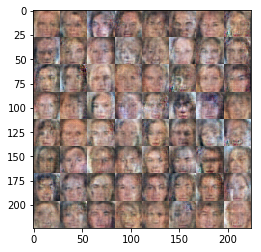

Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 2.8319... Generator Loss: 0.0721
Epoch 1/1... Discriminator Loss: 3.5469... Generator Loss: 0.0399
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.8070... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 2.1391... Generator Loss: 0.1513
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 2.5116... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 3.0222... Generator Loss: 0.0541


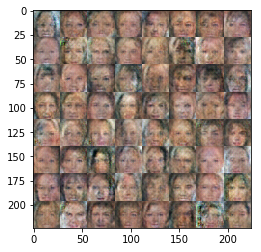

Epoch 1/1... Discriminator Loss: 2.8703... Generator Loss: 0.0690
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.5958
Epoch 1/1... Discriminator Loss: 2.4991... Generator Loss: 0.1110
Epoch 1/1... Discriminator Loss: 2.1369... Generator Loss: 0.1905
Epoch 1/1... Discriminator Loss: 3.8345... Generator Loss: 0.0328
Epoch 1/1... Discriminator Loss: 2.4424... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 2.0862... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.7514


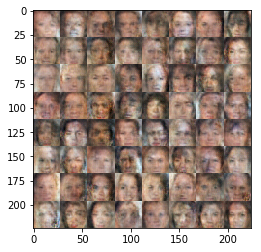

Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 0.3009
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.8298... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 2.0963... Generator Loss: 0.1588
Epoch 1/1... Discriminator Loss: 2.2309... Generator Loss: 0.1283
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 2.6983... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 2.7170... Generator Loss: 0.1045
Epoch 1/1... Discriminator Loss: 2.6471... Generator Loss: 0.0862


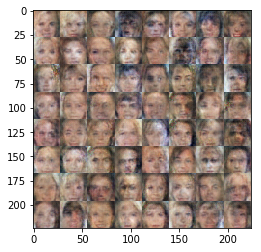

Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 2.7224... Generator Loss: 0.0793
Epoch 1/1... Discriminator Loss: 2.3572... Generator Loss: 0.2121
Epoch 1/1... Discriminator Loss: 2.7306... Generator Loss: 0.0715
Epoch 1/1... Discriminator Loss: 3.0195... Generator Loss: 0.0547
Epoch 1/1... Discriminator Loss: 2.2837... Generator Loss: 0.1310
Epoch 1/1... Discriminator Loss: 2.4449... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 1.8991... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 2.2197... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 0.2820


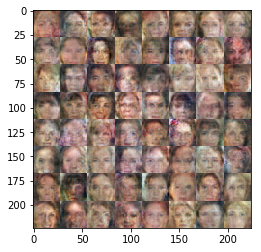

Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.7925... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 2.7192... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 2.0109... Generator Loss: 0.1701
Epoch 1/1... Discriminator Loss: 1.8942... Generator Loss: 0.2224
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.8616... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 2.7425... Generator Loss: 0.0977
Epoch 1/1... Discriminator Loss: 2.0660... Generator Loss: 0.1750
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.2600


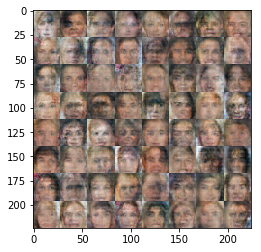

Epoch 1/1... Discriminator Loss: 2.3714... Generator Loss: 0.1466
Epoch 1/1... Discriminator Loss: 2.5571... Generator Loss: 0.1093
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 0.2227
Epoch 1/1... Discriminator Loss: 3.8761... Generator Loss: 0.0281
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 3.5349... Generator Loss: 0.0378
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.9406... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 2.2060... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 1.9057... Generator Loss: 0.2669


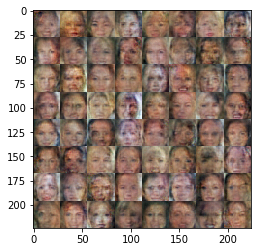

Epoch 1/1... Discriminator Loss: 2.3427... Generator Loss: 0.1191
Epoch 1/1... Discriminator Loss: 2.1057... Generator Loss: 0.1517
Epoch 1/1... Discriminator Loss: 2.0358... Generator Loss: 0.1895
Epoch 1/1... Discriminator Loss: 2.6294... Generator Loss: 0.0875
Epoch 1/1... Discriminator Loss: 2.6095... Generator Loss: 0.0882
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.3357
Epoch 1/1... Discriminator Loss: 3.3543... Generator Loss: 0.0420
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 2.0194... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 3.2494... Generator Loss: 0.0461


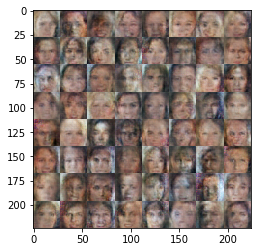

Epoch 1/1... Discriminator Loss: 2.0259... Generator Loss: 0.1783
Epoch 1/1... Discriminator Loss: 1.8464... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 1.6844... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.8402... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.9491... Generator Loss: 0.1965
Epoch 1/1... Discriminator Loss: 2.2992... Generator Loss: 0.1252
Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.3423


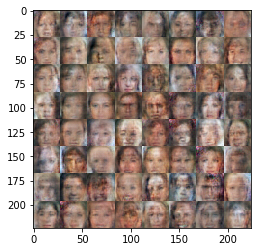

Epoch 1/1... Discriminator Loss: 2.2947... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 1.9497... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 2.3327... Generator Loss: 0.1144
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 2.2527... Generator Loss: 0.1260
Epoch 1/1... Discriminator Loss: 1.7848... Generator Loss: 0.2778
Epoch 1/1... Discriminator Loss: 2.4516... Generator Loss: 0.1048
Epoch 1/1... Discriminator Loss: 2.1333... Generator Loss: 0.1690
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7132


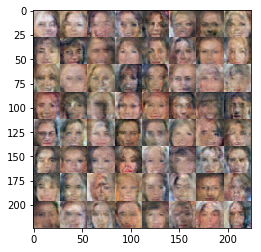

Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.3618
Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 2.3709... Generator Loss: 0.1235
Epoch 1/1... Discriminator Loss: 2.5136... Generator Loss: 0.1133
Epoch 1/1... Discriminator Loss: 2.1650... Generator Loss: 0.1342
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.9378... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 2.4816... Generator Loss: 0.1099


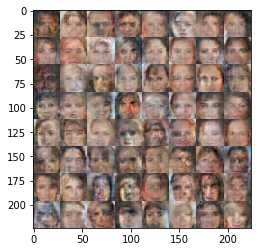

Epoch 1/1... Discriminator Loss: 2.3600... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 2.9781... Generator Loss: 0.0755
Epoch 1/1... Discriminator Loss: 2.3464... Generator Loss: 2.2808
Epoch 1/1... Discriminator Loss: 2.3728... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 2.0201... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 2.4349... Generator Loss: 0.1597
Epoch 1/1... Discriminator Loss: 2.2274... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 3.5283... Generator Loss: 0.0491
Epoch 1/1... Discriminator Loss: 1.9168... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 2.3198... Generator Loss: 0.7755


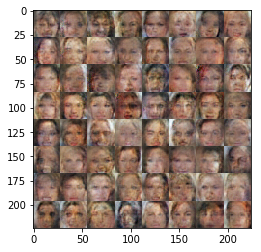

Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 3.0071... Generator Loss: 0.0634
Epoch 1/1... Discriminator Loss: 2.6249... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 3.0238... Generator Loss: 0.0625
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 2.1143... Generator Loss: 0.2454


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
print('done')

In [ ]:
2+2

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.